##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/deepdream"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/deepdream.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/deepdream.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/deepdream.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程包含 DeepDream 的最小规模实现，如此篇由 Alexander Mordvintsev 发布的[博文](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)所述。

DeepDream 是一项将神经网络学习模式予以可视化展现的实验。与孩子们观察云朵并尝试解释随机形状相类似，DeepDream 会过度解释并增强其在图像中看到的图案。

该技术的原理是通过网络转发图像，然后计算图像相对于特定层激活的梯度。随后，图像将被修改以增加这些激活，从而增强网络可识别到的图案，并生成梦境般的图像。该过程被称为“盗梦”（引用自 [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf)，以及[电影](https://en.wikipedia.org/wiki/Inception)《盗梦空间》）。

让我们演示如何帮助神经网络“造梦”并增强其在图像中识别到的超现实图案。

![Dogception](https://tensorflow.google.cn/tutorials/generative/images/dogception.png)

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## 选择要梦境化的图像

在本教程中，我们使用了[拉布拉多寻回犬](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)的图片。

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


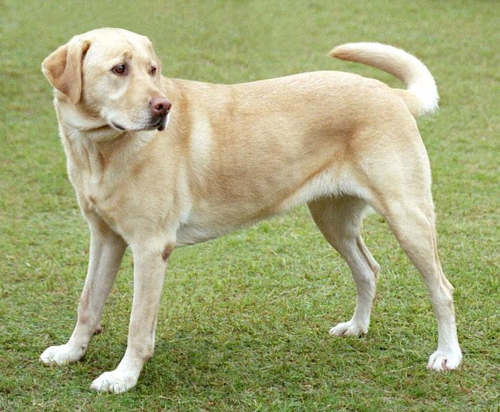

In [4]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## 准备特征提取模型

下载并准备预训练的图像分类模型。您将使用 [InceptionV3](https://keras.io/applications/#inceptionv3)，它与 DeepDream 中最初使用的模型相似。请注意，任何[预训练模型](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet)均可使用，但如果对其进行了更改，则您需要调整下方的层名称。

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


DeepDream 的方案是选择一个或多个层，并以使图像渐增式“激发”层的方式最大化“损失”。融入特征的复杂性取决于您选择的层，即较低的层会产生笔触或简单的图案，而较深的层则会使图像甚至整个对象呈现出复杂的特征。

InceptionV3 架构十分庞大（有关模型架构的图表，请参见 TensorFlow 的[研究仓库](https://github.com/tensorflow/models/tree/master/research/inception)）。对于 DeepDream，目标层是将卷积串联在一起的层。InceptionV3 中有 11 层，名为“mixed0”至“mixed10”。使用不同的层将产生不同的梦幻图像。较深的层响应较高级的特征（例如，眼睛和面部），而较浅的层则响应较简单的特征（例如，边缘、形状和纹理）。请随意尝试以下选择的层，但请记住，由于梯度计算的深度较大，较深的层（索引较高的层）将需要较长的训练时间。

In [6]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## 计算损失

损失是所选层中激活的总和。损失在每一层均会进行归一化，因此较大层的贡献不会超过较小层。通常，您会希望通过梯度下降来实现损失量最小化。但在 DeepDream 中，您将通过梯度上升使这种损失最大化。

In [7]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## 梯度上升

所选层的损失一旦计算完成，只需相对于图像计算梯度，并将梯度添加到原始图像即可。

将梯度添加到图像后，网络可以更清晰地识别图案。在每个步骤中，您都将创建一个图像，从而渐增式地激发网络中某些层的激活。

下文提供了执行此操作的方法，即包装在 `tf.function` 中，从而提升性能。它使用 `input_signature` 来确保不会因图像大小不一或 `steps`/`step_size` 值不同而回溯函数。有关详细信息，请参阅[具体函数指南](../../guide/concrete_function.ipynb)。

In [8]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [11]:
deepdream = DeepDream(dream_model)

## 主循环

In [9]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

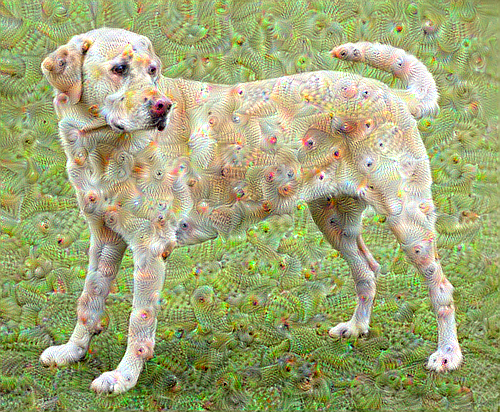

In [12]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)

## 调高八度

很好，但是首次尝试会有一些问题：

1. 输出有噪声（可以使用 `tf.image.total_variation` 损失加以解决）。
2. 图像分辨率低。
3. 图案看起来粒度全部相同。

一种可以解决所有上述问题的方法是以不同比例应用梯度上升。这将使在较小比例下生成的图案能够融合到较大比例的图案中，并附加其他细节。

为此，您可以执行以前的梯度上升方法，然后增大图像尺寸（称为八度），并对多个八度重复此过程。

在传统的模型训练中，Loss 代表“错误”。但在 DeepDream 里，我们将 Loss 定义为**“目标层神经元激活值的平均值”**。

我们的目标是：让这个 Loss 越大越好（即神经元反应越剧烈）

模拟神经网络的感受野（Receptive Field）。
1. 为什么“单比例”不行？感受野限制： 神经网络的每一层都有固定的“视野”范围。如果你只在原始高分辨率图上操作，卷积核每次只能看到几个像素点。它想画一只“狗”，但因为视野太窄，最后只能画出一堆细碎的“狗毛”纹理。噪声堆积： 梯度上升非常激进，它会放大每一个微小的像素波动。如果没有宏观约束，这些波动就会演变成高频噪声（Static noise）
2. 八度（Octave）是如何解决问题的？通过将图像缩小（构建图像金字塔），我们强行让模型的“视野”相对变大了。A. 解决“粒度相同”：跨尺度的特征融合小尺寸（低八度）： 当图像缩小时，原本 $3 \times 3$ 的卷积核现在能覆盖原图更大范围的区域。模型此时能“构图”，确定大轮廓（比如头的形状）。大尺寸（高八度）： 随着图像放大，模型开始填充细节（比如眼球的质感）。结果： 最终图像既有宏观的结构，又有微观的精致，层级感分明。B. 解决“分辨率低”与“噪声”：递归式精化： 你先在极小的图上生成一个模糊但正确的幻觉，然后放大它，把它作为“底稿”交给下一层。自然平滑： 在放大图像的过程中（Up-sampling），本质上进行了一次插值，这天然地起到了一种低通滤波的作用，抵消了上一层产生的部分高频噪声。
3. 操作流程：如何实现“调高八度”？定义金字塔： 将原图缩放成一系列尺寸，比如 $1/4 \times$, $1/2 \times$, $1 \times$。从小到大迭代：在最小的图上跑梯度上升。将结果放大到下一个尺寸。关键点（注入细节）： 放大后的图会变模糊，此时需要把原图在该尺寸下的“丢失细节”补回来（通常用原图减去缩放后的图得到残差），然后再跑梯度上升。
4. 损失函数的助攻：Total Variation (TV) Loss你提到的 tf.image.total_variation 是神来之笔。原理： 它计算图像中相邻像素之间的差异。作用： 它像是一个“平滑约束器”。如果某个像素突变太快（噪点），TV Loss 就会变大。通过最小化这个 Loss，我们强迫模型生成的图案更加平滑、连贯，看起来更像真实的物体而不是电子雪花。

计算残差： $Res = A - A_{blur}$（这时候 $Res$ 看起来是灰蒙蒙的，只有线条）！！！



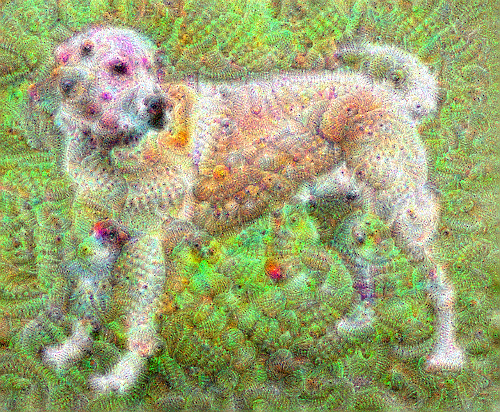

104.82179856300354

In [21]:
import time
start = time.time() # 记录开始时间，用于性能评估

OCTAVE_SCALE = 3.00 # 八度缩放比例。意味着每一级图像的尺寸会是上一级的 3 倍

img = tf.constant(np.array(original_img)) # 将原始图片转换为 TensorFlow 张量
base_shape = tf.shape(img)[:-1] # 获取原图的高、宽（排除颜色通道）
float_base_shape = tf.cast(base_shape, tf.float32) # 转为浮点型以便后续做乘法运算

# 核心循环：n 从 -2 到 2，共 5 个尺度（八度）
for n in range(-2, 3):
    # 计算当前尺度下的新形状：原图尺寸 * (3.0 的 n 次方)
    # n=-2: 1/9 尺寸; n=0: 原图尺寸; n=2: 9 倍尺寸
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    # 调整图像大小。注意：.numpy() 会将张量转回 numpy 数组，方便传递给简单处理函数
    img = tf.image.resize(img, new_shape).numpy()

    # 在当前尺度上执行 50 步梯度上升
    # 这一步是产生“幻觉”的关键，img 会被微调
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True) # 清除 Jupyter 单元格输出，准备显示最终图像

# 最终处理：将产生幻觉后的图像强制缩放回原图大小
img = tf.image.resize(img, base_shape)
# 归一化并转为 uint8 格式（0-255 像素值），以便正常显示图片
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img) # 调用显示函数

end = time.time()
end-start # 输出总耗时

## 可选：按比例增加图块

需要考虑的是，随着图像尺寸增大，执行梯度计算所需时间和内存也将随之增加。上文的八度实现不适用于非常大的图像或许多个八度。

为避免此问题，您可以将图像拆分为图块并为每个图块计算梯度。

在每次图块计算之前对图像应用随机偏移可防止出现图块缝隙。

首先实现随机偏移：

In [14]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

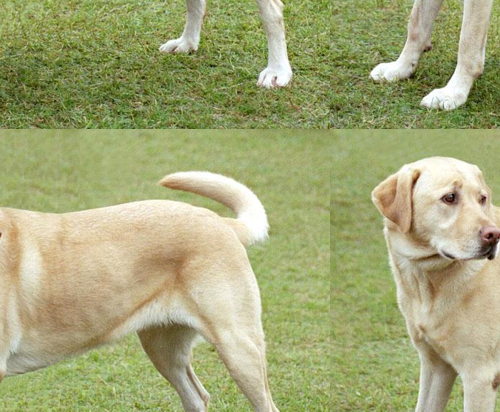

In [15]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

以下为此前定义的 `deepdream` 函数的图块式等效项：

In [16]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [17]:
get_tiled_gradients = TiledGradients(dream_model)

将此组合到一起可提供能够感知八度的可扩展 Deepdream 实现：

In [18]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

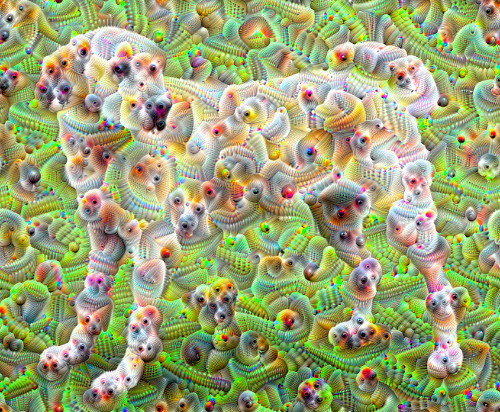

In [19]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

好多了！调整八度数量、八度范围和激活层，以更改 DeepDream 图像的外观。

读者可能还会有兴趣了解 [TensorFlow Lucid](https://github.com/tensorflow/lucid)，其中对本教程中介绍的用于可视化和解释神经网络的理念进行了扩展。